## Предсказание пола/возраста по посещениям сайтов

Для начала, подключим хранилище s3, содержащее исходные данные:

In [9]:
!chmod 600 .s3_passwd
!mkdir -p mnt
!s3fs hsevkhack mnt -o url=http://hb.vkcs.cloud -o use_path_request_style -o passwd_file=.s3_passwd -o ro

Убедимся, что в директории `mnt` содержатся соответствующие таблицы:

In [10]:
!ls mnt/

geo_dataframe.csv  requests  train_users.csv


Если по каким-то причинам директорию смонтировать не удалось, используйте код ниже, чтобы скачать данные к себе в локальное хранилище. В противном случае **пропустите следующую ячейку**.

In [ ]:
import subprocess
!mkdir -p data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv -P data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv -P data
!mkdir -p data/requests
for i in range(30):
    print(f"Downloading part {i}...")
    subprocess.call(["wget", f"https://hsehack.hb.ru-msk.vkcs.cloud/requests/part_{i}.parquet", "-q", "-P", "data/requests"])

## Опции

In [ ]:
#prefix = 's3'
prefix = '.'

low_memory = True

## Загружаем данные

Используем Pandas для работы с таблицами. `geo_dataframe` содержит данные о геолокации - регионе и стране.

In [1]:
import pandas as pd

geo = pd.read_csv(prefix+'/geo_dataframe.csv')
geo

,geo_id,region_id,country_id
0,1,157,40
1,2,161,40
2,3,265,54
3,4,122,54
4,5,78,40
...,...,...,...
5528,5529,246,54
5529,5530,-1,63
5530,5531,101,40
5531,5532,21,68


Таблица `train_users` - это ваша обучающая выборка, содержащая пол и возраст пользователей. Аналогичная таблица для тестового датасета будет вам предоставлена за час до stop coding.

In [2]:
users = pd.read_csv(prefix+'/train_users.csv')
users

,user_id,gender,age
0,2,1,61
1,3,1,55
2,6,0,46
3,14,0,66
4,17,0,53
...,...,...,...
4999995,17588859,1,64
4999996,17588860,0,69
4999997,17588861,1,51
4999998,17588864,0,30


Для примера - вот распределение пользователей по полу:

<Axes: xlabel='gender'>

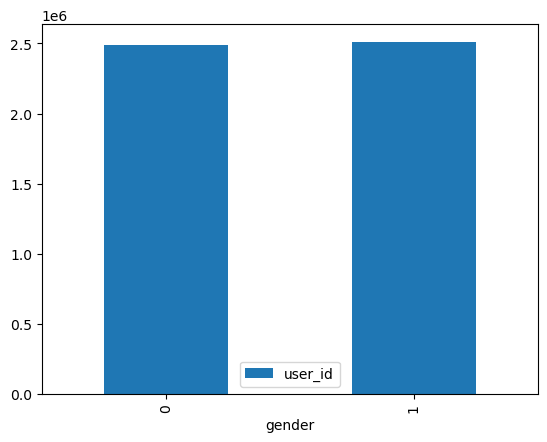

In [3]:
users.groupby('gender').agg({ 'user_id' : len }).plot.bar()

<Axes: xlabel='age'>

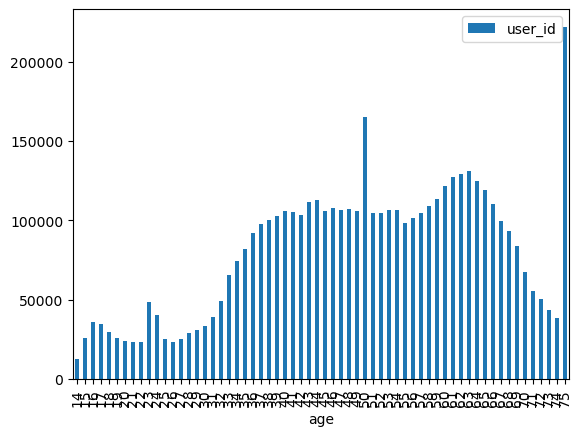

In [3]:
users.groupby('age').agg({ 'user_id' : len }).plot.bar()

Основные данные о посещениях пользователями сайтов содержатся в табличке `requests`, представленной в формате parquet. Вы можете загрузить только одну часть таблички, или же всю таблицу, если она поместиться в памяти:

In [5]:
req1 = pd.read_parquet(prefix+'/requests/part_0.parquet')
req1

,timestamp,geo_id,referer,user_id,user_agent
0,1712169477,1224,https://www.domain_1118/path_107938,1628092,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
1,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...
2,1712154596,4402,https://domain_2194/path_172150,8274161,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
...,...,...,...,...,...
10000449,1712161101,702,https://domain_662/path_131980,2062442,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
10000450,1711940706,3515,https://domain_1784/path_45033,2375719,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
10000451,1712107755,3173,https://domain_1654/path_48166,11781572,Mozilla/5.0 (Linux; arm_64; Android 13; SM-A14...
10000452,1712107427,3833,https://domain_1654/path_10504,15183751,Mozilla/5.0 (Linux; arm_64; Android 12; SM-M21...


## Дерзайте!

Вам необходимо построить предсказательную модель для прогнозирования пола и возраста пользователей по их посещениям. Таблица с тестовыми пользователями будет предоставлена вам за час до stop coding.

ВАЖНО:
* Таблицу с тестовыми данными нельзя использовать для обучения модели. Если жюри увидит, что вы использовали табличку с тестовыми данными - точность модели будет оцениваться в 0 баллов.
* В ходе выступления необходимо продемонстрировать точность модели на тестовых данных.

### util

In [6]:
import time
import datetime

#current_time = time.time()
current_time = 1712169477

dt_object = datetime.datetime.fromtimestamp(current_time)
print(dt_object)

2024-04-03 21:37:57


In [7]:
def extract_domain_id(s: str):
    if len(s) == 0:
        return -1
    pattern1 = 'domain_'
    pattern2 = 'path_'
    idx = s.find(pattern1)+len(pattern1)
    idx2 = s.find(pattern2)+len(pattern2)
    return int(s[idx:idx+s[idx:].find('/')])#, int(s[idx2:])

examples = ['https://www.domain_1118/path_107938', 'https://domain_3207/path_175610']
list(map(extract_domain_id, examples))

[1118, 3207]

In [12]:
if low_memory:
    req1.drop(columns='user_agent', axis=1, inplace=True)
req1['domain_id'] = req1['referer'].apply(extract_domain_id)
if low_memory:
    req1.drop(columns='referer', axis=1, inplace=True)
req1

In [13]:
req1 = pd.merge(req1, users, on='user_id', how='inner')
req1

,timestamp,geo_id,user_id,domain_id,gender,age
0,1711945301,2540,1013613,3207,1,75
1,1711972560,2540,1013613,207,1,75
2,1711954939,2540,1013613,698,1,75
3,1711941903,3833,17082498,2042,0,72
4,1712044263,3833,17082498,2042,0,72
...,...,...,...,...,...,...
4661102,1711976568,2293,6656337,1892,0,41
4661103,1711941218,2712,5917152,1654,1,58
4661104,1712045245,860,2103837,11,1,53
4661105,1712145174,302,10496894,662,1,59


<Axes: xlabel='domain_id'>

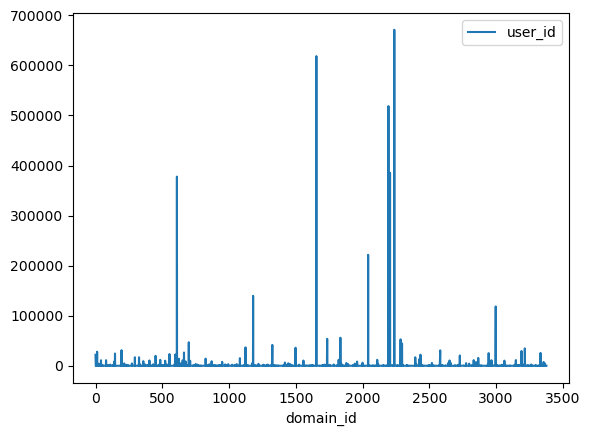

In [14]:

req1.groupby('domain_id').agg({ 'user_id' : len }).plot()

In [15]:
#user_reqs = req.groupby('user_id')['domain_id'].apply(list)
user_reqs = req1.groupby('user_id').agg(
    domain_id=('domain_id', list),
    timestamp=('timestamp', list),
    gender=('gender', list),
    age=('age', list),
    geo_id=('geo_id', list)
)
type(user_reqs), user_reqs[:10]

(pandas.core.frame.DataFrame,
                         domain_id  \
 user_id                             
 2                          [1654]   
 3                      [2867, 78]   
 6                          [3194]   
 20                          [449]   
 23                         [2729]   
 25                     [145, 145]   
 31                   [2206, 2206]   
 32                           [-1]   
 43                   [1654, 1654]   
 46       [3168, 2206, 2285, 2042]   
 
                                                 timestamp        gender  \
 user_id                                                                   
 2                                            [1712017297]           [1]   
 3                                [1712158201, 1712082733]        [1, 1]   
 6                                            [1711966047]           [0]   
 20                                           [1711961988]           [0]   
 23                                           [171205095

In [19]:
for index, rows in user_reqs.iterrows(): 
    print(rows)

    break
user_reqs

domain_id          [1654]
timestamp    [1712017297]
gender                [1]
age                  [61]
geo_id              [708]
Name: 2, dtype: object


,domain_id,timestamp,gender,age,geo_id
user_id,,,,,
2,[1654],[1712017297],[1],[61],[708]
3,"[2867, 78]","[1712158201, 1712082733]","[1, 1]","[55, 55]","[150, 150]"
6,[3194],[1711966047],[0],[46],[3173]
20,[449],[1711961988],[0],[15],[5368]
23,[2729],[1712050954],[1],[48],[3833]
...,...,...,...,...,...
17588853,"[2434, 2434, 2434, 609]","[1712132630, 1712139434, 1711949850, 1711949802]","[0, 0, 0, 0]","[44, 44, 44, 44]","[3827, 3827, 3827, 3827]"
17588855,"[-1, 3019]","[1712104936, 1712105817]","[1, 1]","[50, 50]","[34, 34]"
17588860,"[2238, 2238, 2238, 2042, 609, 2238, 2238, 2238]","[1712022186, 1712024363, 1712021929, 171207907...","[0, 0, 0, 0, 0, 0, 0, 0]","[69, 69, 69, 69, 69, 69, 69, 69]","[3173, 3173, 3173, 3173, 3173, 3173, 3173, 3173]"
